## Loading data

import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

import pymorphy2
import re

load csv file 

In [2]:
fields = ['sku', 'comment', 'commentNegative', 'commentPositive', 'reting']
raw_data = pd.read_csv('feedback.csv/X_train.csv', delimiter=',', usecols=fields)
print('Data frame size:',raw_data.shape)

Data frame size: (15587, 5)


## Preprocessing

display the distribution of ratings

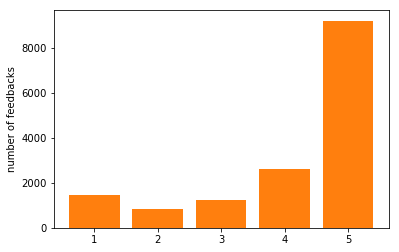

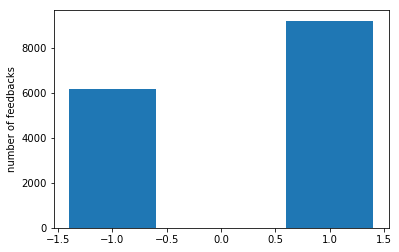

In [16]:
def arrangeBy(data, param):
    r_data = {}
    for row in data:
        r = row[param]
        if r in r_data:
            r_data[r].append(row)
        else:
            r_data[r] = []
    return collections.OrderedDict(sorted(r_data.items()))

def plotDist(data):
    ratings = list(data.keys())
    numbers = list(map(lambda x: len(x), data.values()))

    plt.bar(ratings,numbers)
    plt.ylabel('number of feedbacks')
    plt.show()

rows_all = list(map(lambda x: x[1], raw_data.iterrows()))
rows = []

for row in rows_all:
    isFive = -1
    if not row['reting'].is_integer():
        continue
    if row['reting'] == 5:
        isFive = 1
    row['isFive'] = isFive
    rows.append(row)
    
ratings_data_by_rating = arrangeBy(rows,'reting');
plotDist(ratings_data_by_rating)

ratings_data = arrangeBy(rows,'isFive');
plotDist(ratings_data)

normalize data

In [22]:
rows = list(ratings_data.values())

numbers = list(map(lambda x: len(x), rows))
feedbacks_per_rating = sum(numbers) - max(numbers)

print('five rates number:',max(numbers))
print('other rates number:',feedbacks_per_rating)

normal_rows = []

normal_rows = rows[0][:]
normal_rows.extend(rows[1][:feedbacks_per_rating])
    
np.random.shuffle(normal_rows)
    
print('feedbacks number:',len(normal_rows))

five rates number: 9210
other rates number: 6175
feedbacks number: 12350


check the distribution of reviews

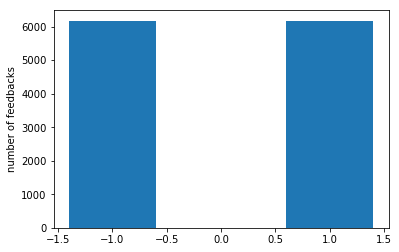

In [23]:
ratings_data = arrangeBy(normal_rows, 'isFive')
plotDist(ratings_data)

## Simple model

In [24]:
count_vectorizer = CountVectorizer(min_df=0.0001, max_df=0.95, ngram_range=(1,3))

def evaluate_cross_validation(clf, X, y, K):
    cv = StratifiedKFold(K, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv) 
    print(scores)
    print("Mean score: {0:.3f} (+/-{1:.3f})".format(scores.mean(), scores.std()))
    
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
X = count_vectorizer.fit_transform((r['comment'] for r in normal_rows))
y = list(r['isFive'] for r in normal_rows)

clf = RandomForestClassifierWithCoef(n_estimators=1500, min_samples_leaf=10, n_jobs=-1)
evaluate_cross_validation(clf, X, y, 3)

[ 0.76274891  0.76943635  0.77915452]
Mean score: 0.770 (+/-0.007)


## Smarter model

morphological normalization, etc.

In [25]:
morph = pymorphy2.MorphAnalyzer()

regex_clear = re.compile('[^а-яё]',re.DOTALL)
regex_space = re.compile('\s{1,}',re.DOTALL)

def clear(text):
    tmp = re.sub(regex_clear, ' ', text.lower().replace('ё', 'е'))
    return re.sub(regex_space, ' ', tmp)

def prepare(text):
    return text.lower()

def to_normal(word):
    return morph.parse(word)[0].normal_form
    
def normalize(text):
    words = []
    for word in text.split(' '):
        words.append(to_normal(word))
    norm=' '.join(words)  
    return norm.replace('ё', 'е')

class TextNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        cleared = [clear(text) for text in texts]
        return [normalize(text) for text in texts]
    
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        return [prepare(text) for text in texts]

In [26]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('count_vectorizer', Pipeline([
                ('selector', TextNormalizer()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, ngram_range=(3,3))),
                #('best', TruncatedSVD(n_components=3000)),
            ])),
            ('tfidf', Pipeline([
                 ('selector', TextNormalizer()),
                 ('tfidf', TfidfVectorizer()),
                 #('best', TruncatedSVD(n_components=100)), 
             ])),
            ('count_vectorizer_default', Pipeline([
                #('selector', TextCleaner()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, ngram_range=(3,3), analyzer='word')),                                
            ])),

        ],
        transformer_weights={ 
            'count_vectorizer': 10,
            'tfidf': 1
       },
    )),

    #('model', SVC(kernel='linear')) #rbf, sigmoid, polynomial
    ('model', RandomForestClassifierWithCoef(n_estimators=768, min_samples_leaf=3, n_jobs=-1))
    
])

comments_x = list(r['comment'] for r in normal_rows)
ratings_y = list(r['isFive'] for r in normal_rows)

evaluate_cross_validation(pipeline, comments_x, ratings_y, 3)

[ 0.75303545  0.75704568  0.76943635]
Mean score: 0.760 (+/-0.007)
